In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
from scipy import signal
import pickle
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
import random
import tensorflow as tf
import cv2
from scipy import stats



In [2]:
#fix all seeds for random number generators
# Set seed value
seed_value = 9
import os
os.environ['PYTHONHASHSEED']=str(seed_value)# 2. Set `python` built-in pseudo-random generator at a fixed value
random.seed(seed_value)# 3. Set `numpy` pseudo-random generator at a fixed value
np.random.seed(seed_value)
tf.random.set_seed(seed_value)# 5. Configure a new global `tensorflow` session

# TODO need to add session thing for tensorflow

# Read Depth Camera

In [3]:
# For reading depth camera
def read_depth_camera(dcamera_path, show_video, nw_resize=1, nh_resize=1):
    video  = cv2.VideoCapture(dcamera_path)
    ret, frame = video.read()
    
    # Get total # of frame count 
    frame_count = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
        
    frame_height = int(frame.shape[0])
    frame_width = int(frame.shape[1])

    
    depth_frames = np.empty((frame_count, int(frame_height/nh_resize), int(frame_width/nw_resize)))
    depth_frames = np.empty((frame_count, int(frame_height/nh_resize), int(frame_width/nw_resize),3))
    count = 0
    while (video.isOpened()):
        ret, frame = video.read()
        
        if ret == True:
#             gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            gray_frame = frame/np.maximum(np.max(frame),255)
            gray_frame = cv2.resize(gray_frame, \
                                    (int(frame_width/nw_resize), int(frame_height/nh_resize)),\
                                    interpolation = cv2.INTER_NEAREST)

            depth_frames[count] = gray_frame
            if show_video == True:
                cv2.imshow("Depth", gray_frame)
                if cv2.waitKey(1) & 0xFF == ord('q'):
                    break
            count = count + 1
        else: 
            break
            

    video.release()
    #cv2.destroyAllWindows()
    return depth_frames

def read_output_data(qtm_file_data, theta):
    if theta=='x':
        qtm_data = pd.read_csv(qtm_file_data, usecols = ["Lean Left/Right Angle (deg)"])
    if theta=='y':
        qtm_data = pd.read_csv(qtm_file_data, usecols = ["Lean Forward/Backwards Angle (deg)"])
    if theta=='z':
        qtm_data = pd.read_csv(qtm_file_data, usecols = ["Torso Twist Angle (deg)"])
        
    
    return qtm_data


In [4]:
def play_video(read_frames):

    for i in range(len(read_frames)):
        # Capture frame-by-frame
        frame = read_frames[i]

        # Display the resulting frame
        plt.imshow(frame)
#         if cv2.waitKey(1) & 0xFF == ord('q'):
#             break
    #cv2.destroyAllWindows()

    return

In [5]:
def show_frame(read_frames, frame_range):
      # Capture frame-by-frame

    # Display the resulting frame
    for i in frame_range:
        fig = plt.figure(figsize=(6,6))        
        a = plt.imshow(read_frames[i])
        
    return

In [58]:
#fix this to concatenate everything
# n_test = 24
# date = '11_15_2020'
# test_str = '/test' + str(n_test)
# #data_dir = r"C:\Users\77bis\Box\CS598 - Final Project\Preliminary Data V4\Test_Subject_Leo" + test_str
# data_dir = "/home/asilador/CS598/CS598-FinalProject/Preliminary Data V4/Test_Subject_Leo" + test_str
# train_dcamera_path = data_dir + '/depth_processed_leo_test'+str(n_test)+'.avi'
# show_video = 0
# n_resize = 1
# x_train = read_depth_camera(train_dcamera_path, show_video, nw_resize=2, nh_resize=3)


n_test = (24,30,31,32,33,35)
nw_resize = 2
nh_resize = 2
xtemp = {}
show_video = 0
for i in range(len(n_test)):
    test_str = '/test' + str(n_test[i])
    data_dir = "/home/asilador/CS598/CS598-FinalProject/Preliminary Data V5/Test_Subject_Leo" + test_str
    train_dcamera_path = data_dir + '/depth_processed_leo_test'+str(n_test[i])+'.avi'
    x_train = read_depth_camera(train_dcamera_path, show_video, nw_resize=nw_resize, nh_resize=nh_resize)
    xtemp[i]=x_train

In [59]:
x_train.shape

(28044, 60, 80, 3)

In [61]:
# tlen = len(xtemp[0])-2 +len(xtemp[1])-2+len(xtemp[2])+len(xtemp[3]) #remove 2 samples from 24
# x_train = np.zeros((tlen,xtemp[0].shape[1],xtemp[0].shape[2],xtemp[0].shape[3]))
# x_train[:len(xtemp[0])-2,:,:,:] = xtemp[0][:len(xtemp[0])-2,:,:,:]
# x_train[(len(xtemp[0])-2):,:,:,:] = xtemp[1][:len(xtemp[1])-2,:,:,:]

tlen = len(xtemp[0]) +len(xtemp[1])+len(xtemp[2])+len(xtemp[3])+len(xtemp[4])+len(xtemp[5]) #remove 2 samples from 24 and 3 from 25
x_train = np.zeros((tlen,xtemp[0].shape[1],xtemp[0].shape[2],xtemp[0].shape[3]))
xrun = len(xtemp[0])
x_train[:xrun,:,:,:] = xtemp[0][:xrun,:,:,:]
xrun1 = xrun + len(xtemp[1])
x_train[xrun:xrun1,:,:,:]=xtemp[1][:xrun1-xrun,:,:,:]
xrun2 = xrun1 + len(xtemp[2])
x_train[xrun1:xrun2,:,:,:] = xtemp[2][:xrun2-xrun1,:,:,:]
xrun3 = xrun2 + len(xtemp[3])
x_train[xrun2:xrun3,:,:,:] = xtemp[3][:xrun3-xrun2,:,:,:]
xrun4 = xrun3 + len(xtemp[4])
x_train[xrun3:xrun4,:,:,:] = xtemp[4][:xrun4-xrun3,:,:,:]
xrun5 = xrun4 + len(xtemp[5])
x_train[xrun4:xrun5,:,:,:] = xtemp[5][:xrun5-xrun4,:,:,:]

## model.summary()

# read fdss data

In [15]:
#### Removed due to possible syncing/noise issue
# n_test = 24
# date = '11_15_2020'
# test_str = 'test' + str(n_test)
# #data_dir = r"C:\Users\77bis\Box\CS598 - Final Project\Preliminary Data V4\Test_Subject_Leo" + test_str
# data_dir = "/home/asilador/CS598/CS598-FinalProject/Preliminary Data V4/Test_Subject_Leo" + "/" + test_str + "/fcss_processed_leo_" + test_str + "_" + date + ".txt"
# tmpdata = pd.read_csv(data_dir)

In [16]:
# tmpdata.head()

# Read Output Data


In [77]:
# n_test = 24
# date = '11_15_2020'
# test_str = '/test' + str(n_test)
# # data_dir = r"C:\Users\77bis\Box\CS598 - Final Project\Preliminary Data V4\Test_Subject_Leo" + test_str
# data_dir = "/home/asilador/CS598/CS598-FinalProject/Preliminary Data V4/Test_Subject_Leo" + test_str
# qtm_file_data_dir = data_dir + '/qtm_processed_leo_test' + str(n_test) + '_' + date + '.txt'
# #show_qtm_plot = True

# y_gt = read_output_data(qtm_file_data_dir,theta_interest).values
# theta_x = read_output_data(qtm_file_data_dir,'x').values
# theta_y = read_output_data(qtm_file_data_dir,'y').values
# theta_z = read_output_data(qtm_file_data_dir,'z').values

n_test = (24,30,31,32,33,35)
date = ('11_15_2020','11_24_2020','11_24_2020','11_25_2020','11_25_2020','11_25_2020')
y_gt = {}
yrun = 0
theta_interest = 'z'
for i in range(len(n_test)):
    test_str = '/test' + str(n_test[i])
    data_dir = "/home/asilador/CS598/CS598-FinalProject/Preliminary Data V5/Test_Subject_Leo" + test_str
    qtm_file_data_dir = data_dir + '/qtm_processed_leo_test' + str(n_test[i]) + '_' + date[i] + '.txt'
    y_gttemp = read_output_data(qtm_file_data_dir,theta_interest).values
    y_gt[i]=y_gttemp
    
tlen = len(y_gt[0])+len(y_gt[1])+len(y_gt[2])+len(y_gt[3])+len(y_gt[4])+len(y_gt[5])
y_train = np.zeros((tlen,1))
xrun = len(y_gt[0])
y_train[:xrun] = y_gt[0][:xrun]
xrun1 = xrun + len(y_gt[1])
y_train[xrun:xrun1]=y_gt[1][:xrun1-xrun]
xrun2 = xrun1 + len(y_gt[2])
y_train[xrun1:xrun2] = y_gt[2][:xrun2-xrun1]
xrun3 = xrun2 + len(y_gt[3])
y_train[xrun2:xrun3] = y_gt[3][:xrun3-xrun2]
xrun4 = xrun3 + len(y_gt[4])
y_train[xrun3:xrun4] = y_gt[4][:xrun4-xrun3]
xrun5 = xrun4 + len(y_gt[5])
y_train[xrun4:xrun5] = y_gt[5][:xrun5-xrun4]

In [80]:
print(x_train.shape)
print(y_train.shape)

(82381, 60, 80, 3)
(82381, 1)


In [81]:
nsamps = x_train.shape[0]
n80p = int(np.floor(nsamps*0.8))
rannums = np.array(random.sample(range(1,nsamps,1), n80p))
s_nfiles = np.arange(nsamps)
test_set = np.setdiff1d(s_nfiles,rannums)

#

In [82]:
Trainset = x_train[rannums,:]
Testset = x_train[test_set,:]
# Trainy= y_gt[rannums,:]
# Testy = y_gt[test_set,:]
Trainy= y_train[rannums,:]
Testy = y_train[test_set,:]

In [83]:
sc_y = StandardScaler()

In [84]:
Xtrainz = Trainset
ytrainz = Trainy
X = Xtrainz
y = sc_y.fit_transform(ytrainz)

In [85]:
#make validation data available to model.fit
Xvalid = Testset

y_valid = Testy
y_valid = sc_y.transform(y_valid)


# Regress using Neural Network

In [86]:
np.max(Xvalid) #7min*30fps*60s/min*0.8 ~ 10800

1.0

In [96]:
# Create Neural Netowrk
# model = tf.keras.Sequential()
# model.add(tf.keras.Input(shape=(X.shape[1],)))
# model.add(tf.keras.layers.Dense(200, activation="relu"))
# #model.add(tf.keras.layers.Dropout(0.5))
# model.add(tf.keras.layers.Dense(200, activation="relu"))
# model.add(tf.keras.layers.Dropout(0.5))          
# model.add(tf.keras.layers.Dense(100, activation='linear')) #added extra layer. probably overkill but want good results
# model.add(tf.keras.layers.Dense(1, activation='linear'))
# model.compile(optimizer='adam',
#               loss='mae',
#               metrics=['mse','mae'])
    
# # loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# # loss_fn(y_train[:1], predictions).numpy()

from keras.layers import Bidirectional, Conv2D, MaxPooling2D, Input, Concatenate, AveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.core import Dense, Activation, Dropout, Reshape, Permute, Flatten
from keras.models import Model

model_start = Input(shape=(x_train.shape[1],x_train.shape[2],x_train.shape[3]))
model_cnn = model_start
# f_pool_size = (5,2,2)
dropout_rate = 0.2
# for i, convCnt in enumerate(f_pool_size):
#     model_cnn = Conv2D(filters=x_train.shape[2], kernel_size=(3, 3))(model_cnn)
#     model_cnn = BatchNormalization()(model_cnn)
#     model_cnn = Activation('relu')(model_cnn)
#     model_cnn = MaxPooling2D(pool_size=(f_pool_size[i], f_pool_size[i]))(model_cnn)
#     model_cnn = Dropout(dropout_rate)(model_cnn)

# model_cnn = Conv2D(filters=8, kernel_size=(3, 3),padding='same')(model_cnn)
# # model_cnn = BatchNormalization()(model_cnn)
# model_cnn = Activation('relu')(model_cnn)
# model_cnn = AveragePooling2D(pool_size=(2, 2))(model_cnn)
# # model_cnn = Dropout(dropout_rate)(model_cnn)

model_cnn = Conv2D(filters=16, kernel_size=(3, 3),padding='same')(model_cnn)
# model_cnn = BatchNormalization()(model_cnn)
model_cnn = Activation('relu')(model_cnn)
model_cnn = AveragePooling2D(pool_size=(2, 2))(model_cnn)
# model_cnn = Dropout(dropout_rate)(model_cnn)

model_cnn = Conv2D(filters=32, kernel_size=(3, 3),padding='same')(model_cnn)
# model_cnn = BatchNormalization()(model_cnn)
model_cnn = Activation('relu')(model_cnn)
model_cnn = AveragePooling2D(pool_size=(2, 2))(model_cnn)
# model_cnn = Dropout(dropout_rate)(model_cnn)

model_cnn = Conv2D(filters=64, kernel_size=(3, 3),padding='same')(model_cnn)
# model_cnn = BatchNormalization()(model_cnn)
model_cnn = Activation('relu')(model_cnn)
model_cnn = AveragePooling2D(pool_size=(2, 2))(model_cnn)
# model_cnn = Dropout(dropout_rate)(model_cnn)

model_cnn = Conv2D(filters=96, kernel_size=(3, 3),padding='same')(model_cnn)
# model_cnn = BatchNormalization()(model_cnn)
model_cnn = Activation('relu')(model_cnn)
model_cnn = AveragePooling2D(pool_size=(2, 2))(model_cnn)
# model_cnn = Dropout(dropout_rate)(model_cnn)

model_cnn = Flatten()(model_cnn)
model_cnn = Activation('relu')(model_cnn)
# model_cnn = Dropout(dropout_rate)(model_cnn)

model_cnn = Dense(128)(model_cnn)
model_cnn = Activation('relu')(model_cnn)
model_cnn = Dropout(dropout_rate)(model_cnn)

# model_cnn = Dense(200)(model_cnn)
# model_cnn = Activation('relu')(model_cnn)
# model_cnn = Dropout(dropout_rate)(model_cnn)

output = Dense(1)(model_cnn)
output = Activation('linear', name='thetaz_out')(output)
model = Model(inputs=model_start,outputs=output)
model.compile(optimizer='adam',
              loss='mae',
              metrics=['mse','mae'])


callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50,restore_best_weights=True) #Moving to 1000 patience. 
model.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 60, 80, 3)         0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 60, 80, 16)        448       
_________________________________________________________________
activation_37 (Activation)   (None, 60, 80, 16)        0         
_________________________________________________________________
average_pooling2d_25 (Averag (None, 30, 40, 16)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 30, 40, 32)        4640      
_________________________________________________________________
activation_38 (Activation)   (None, 30, 40, 32)        0         
_________________________________________________________________
average_pooling2d_26 (Averag (None, 15, 20, 32)        0   

In [97]:
epochs = int(30000)
batch_size = 256
history = model.fit(X, y,batch_size=batch_size, epochs = epochs,callbacks = [callback],validation_data = (Xvalid, y_valid),verbose=2)

# model.save('depthforcemodel.h5')
#history.save('depthforcehist.h5')

Train on 65904 samples, validate on 16477 samples
Epoch 1/30000
 - 8s - loss: 0.6192 - mse: 0.9185 - mae: 0.6192 - val_loss: 0.5744 - val_mse: 0.7754 - val_mae: 0.5744
Epoch 2/30000
 - 8s - loss: 0.5607 - mse: 0.7916 - mae: 0.5607 - val_loss: 0.5355 - val_mse: 0.7298 - val_mae: 0.5355
Epoch 3/30000
 - 8s - loss: 0.5321 - mse: 0.7454 - mae: 0.5321 - val_loss: 0.5135 - val_mse: 0.6932 - val_mae: 0.5135
Epoch 4/30000
 - 8s - loss: 0.5119 - mse: 0.7133 - mae: 0.5119 - val_loss: 0.4971 - val_mse: 0.6662 - val_mae: 0.4971
Epoch 5/30000
 - 8s - loss: 0.4948 - mse: 0.6881 - mae: 0.4948 - val_loss: 0.4869 - val_mse: 0.6494 - val_mae: 0.4869
Epoch 6/30000
 - 8s - loss: 0.4792 - mse: 0.6652 - mae: 0.4792 - val_loss: 0.4666 - val_mse: 0.6169 - val_mae: 0.4666
Epoch 7/30000
 - 8s - loss: 0.4654 - mse: 0.6430 - mae: 0.4654 - val_loss: 0.4555 - val_mse: 0.6015 - val_mae: 0.4555
Epoch 8/30000
 - 8s - loss: 0.4527 - mse: 0.6251 - mae: 0.4527 - val_loss: 0.4404 - val_mse: 0.5790 - val_mae: 0.4404
Epoch 

Epoch 70/30000
 - 8s - loss: 0.2288 - mse: 0.2677 - mae: 0.2288 - val_loss: 0.2692 - val_mse: 0.3054 - val_mae: 0.2692
Epoch 71/30000
 - 8s - loss: 0.2288 - mse: 0.2666 - mae: 0.2288 - val_loss: 0.2639 - val_mse: 0.3025 - val_mae: 0.2639
Epoch 72/30000
 - 8s - loss: 0.2283 - mse: 0.2650 - mae: 0.2283 - val_loss: 0.2606 - val_mse: 0.3015 - val_mae: 0.2606
Epoch 73/30000
 - 8s - loss: 0.2261 - mse: 0.2599 - mae: 0.2261 - val_loss: 0.2589 - val_mse: 0.2983 - val_mae: 0.2589
Epoch 74/30000
 - 8s - loss: 0.2255 - mse: 0.2606 - mae: 0.2255 - val_loss: 0.2666 - val_mse: 0.3017 - val_mae: 0.2666
Epoch 75/30000
 - 8s - loss: 0.2270 - mse: 0.2610 - mae: 0.2270 - val_loss: 0.2558 - val_mse: 0.2924 - val_mae: 0.2558
Epoch 76/30000
 - 8s - loss: 0.2230 - mse: 0.2584 - mae: 0.2230 - val_loss: 0.2533 - val_mse: 0.2958 - val_mae: 0.2533
Epoch 77/30000
 - 8s - loss: 0.2222 - mse: 0.2569 - mae: 0.2222 - val_loss: 0.2573 - val_mse: 0.2978 - val_mae: 0.2573
Epoch 78/30000
 - 8s - loss: 0.2217 - mse: 0.255

Epoch 139/30000
 - 8s - loss: 0.1836 - mse: 0.1814 - mae: 0.1836 - val_loss: 0.2430 - val_mse: 0.2423 - val_mae: 0.2430
Epoch 140/30000
 - 8s - loss: 0.1839 - mse: 0.1801 - mae: 0.1839 - val_loss: 0.2363 - val_mse: 0.2419 - val_mae: 0.2363
Epoch 141/30000
 - 8s - loss: 0.1845 - mse: 0.1811 - mae: 0.1845 - val_loss: 0.2377 - val_mse: 0.2407 - val_mae: 0.2377
Epoch 142/30000
 - 8s - loss: 0.1826 - mse: 0.1790 - mae: 0.1826 - val_loss: 0.2336 - val_mse: 0.2362 - val_mae: 0.2336
Epoch 143/30000
 - 8s - loss: 0.1817 - mse: 0.1759 - mae: 0.1817 - val_loss: 0.2369 - val_mse: 0.2407 - val_mae: 0.2369
Epoch 144/30000
 - 8s - loss: 0.1816 - mse: 0.1752 - mae: 0.1816 - val_loss: 0.2372 - val_mse: 0.2421 - val_mae: 0.2372
Epoch 145/30000
 - 8s - loss: 0.1809 - mse: 0.1765 - mae: 0.1809 - val_loss: 0.2367 - val_mse: 0.2452 - val_mae: 0.2367
Epoch 146/30000
 - 8s - loss: 0.1816 - mse: 0.1753 - mae: 0.1816 - val_loss: 0.2364 - val_mse: 0.2443 - val_mae: 0.2364
Epoch 147/30000
 - 8s - loss: 0.1823 - m

Epoch 208/30000
 - 8s - loss: 0.1640 - mse: 0.1517 - mae: 0.1640 - val_loss: 0.2339 - val_mse: 0.2339 - val_mae: 0.2339
Epoch 209/30000
 - 8s - loss: 0.1631 - mse: 0.1494 - mae: 0.1631 - val_loss: 0.2308 - val_mse: 0.2279 - val_mae: 0.2308
Epoch 210/30000
 - 8s - loss: 0.1631 - mse: 0.1507 - mae: 0.1631 - val_loss: 0.2322 - val_mse: 0.2293 - val_mae: 0.2322
Epoch 211/30000
 - 8s - loss: 0.1630 - mse: 0.1493 - mae: 0.1630 - val_loss: 0.2307 - val_mse: 0.2287 - val_mae: 0.2307
Epoch 212/30000
 - 8s - loss: 0.1629 - mse: 0.1511 - mae: 0.1629 - val_loss: 0.2338 - val_mse: 0.2314 - val_mae: 0.2338
Epoch 213/30000
 - 8s - loss: 0.1633 - mse: 0.1513 - mae: 0.1633 - val_loss: 0.2348 - val_mse: 0.2346 - val_mae: 0.2348
Epoch 214/30000
 - 8s - loss: 0.1625 - mse: 0.1500 - mae: 0.1625 - val_loss: 0.2338 - val_mse: 0.2302 - val_mae: 0.2338
Epoch 215/30000
 - 8s - loss: 0.1617 - mse: 0.1487 - mae: 0.1617 - val_loss: 0.2313 - val_mse: 0.2314 - val_mae: 0.2313
Epoch 216/30000
 - 8s - loss: 0.1628 - m

Epoch 277/30000
 - 8s - loss: 0.1532 - mse: 0.1373 - mae: 0.1532 - val_loss: 0.2277 - val_mse: 0.2244 - val_mae: 0.2277
Epoch 278/30000
 - 8s - loss: 0.1528 - mse: 0.1371 - mae: 0.1528 - val_loss: 0.2292 - val_mse: 0.2220 - val_mae: 0.2292
Epoch 279/30000
 - 8s - loss: 0.1526 - mse: 0.1369 - mae: 0.1526 - val_loss: 0.2308 - val_mse: 0.2309 - val_mae: 0.2308
Epoch 280/30000
 - 8s - loss: 0.1533 - mse: 0.1367 - mae: 0.1533 - val_loss: 0.2293 - val_mse: 0.2262 - val_mae: 0.2293
Epoch 281/30000
 - 8s - loss: 0.1517 - mse: 0.1362 - mae: 0.1517 - val_loss: 0.2287 - val_mse: 0.2205 - val_mae: 0.2287
Epoch 282/30000
 - 8s - loss: 0.1523 - mse: 0.1364 - mae: 0.1523 - val_loss: 0.2291 - val_mse: 0.2217 - val_mae: 0.2291
Epoch 283/30000
 - 8s - loss: 0.1517 - mse: 0.1359 - mae: 0.1517 - val_loss: 0.2284 - val_mse: 0.2209 - val_mae: 0.2284
Epoch 284/30000
 - 8s - loss: 0.1524 - mse: 0.1364 - mae: 0.1524 - val_loss: 0.2276 - val_mse: 0.2263 - val_mae: 0.2276
Epoch 285/30000
 - 8s - loss: 0.1512 - m

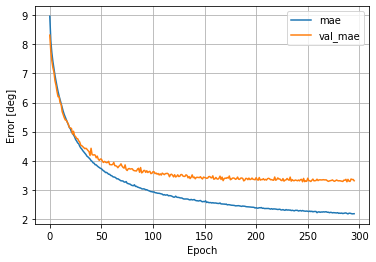

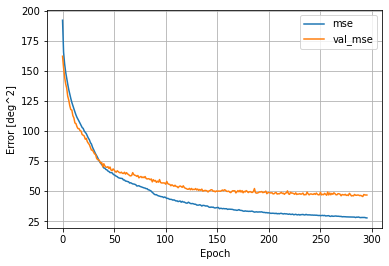

In [98]:
def plot_loss(history):
    
    v1 = history.history['mae']*np.sqrt(sc_y.var_)
    v2 = history.history['val_mae']*np.sqrt(sc_y.var_)
    fig1 = plt.figure()
    ax1 = fig1.add_subplot(111)
    ax1.plot(v1, label='mae')
    ax1.plot(v2, label='val_mae')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Error [deg]')
    ax1.legend()
    ax1.grid(True)
    plt.show()
    
    v3 = history.history['mse']*sc_y.var_
    v4 = history.history['val_mse']*sc_y.var_
    fig2 = plt.figure()
    ax2 = fig2.add_subplot(111)
    ax2.plot(v3, label='mse')
    ax2.plot(v4, label='val_mse')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Error [deg^2]')
    ax2.legend()
    ax2.grid(True)
    plt.show()
    
    
plot_loss(history)


### 4-layer Network: Predict Against Training Data as a Sanity Check

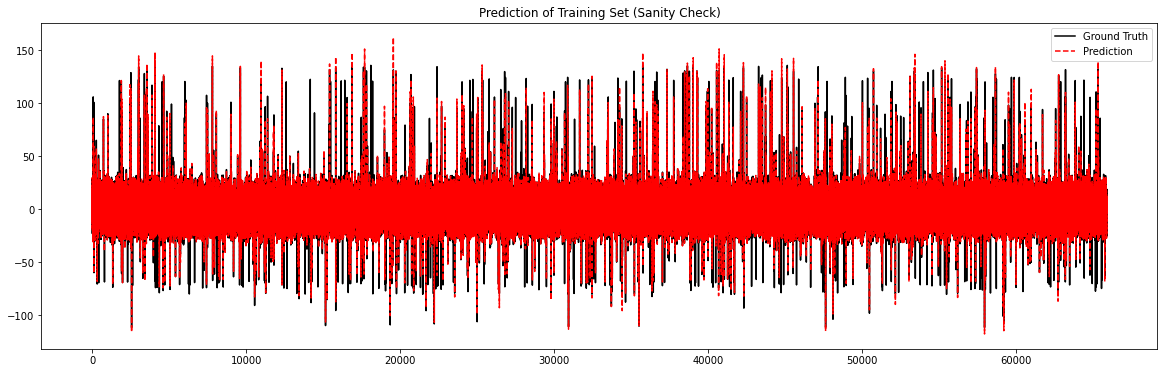

Average error is 0.21 degrees
Root Mean Squared Error is 1.60 degrees
Mean Absolute Error is 1.60 degrees


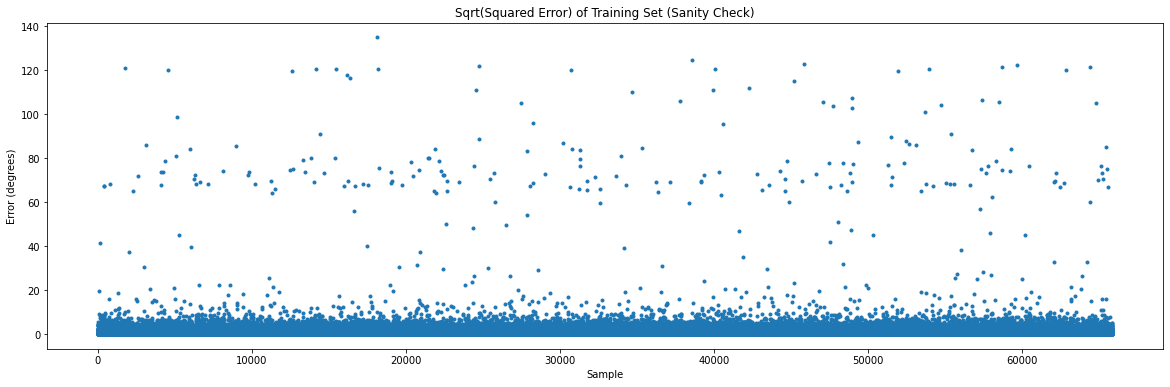

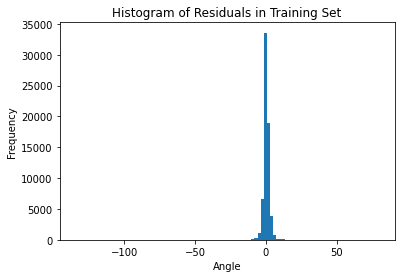

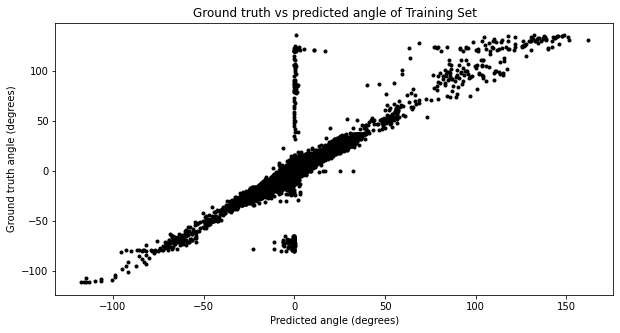

In [99]:

# sanity check with 80% data
Xtrain = Trainset
y_pred = model.predict(Xtrain)
#y_pred = sc_y.inverse_transform(y_pred)
y_pred = sc_y.inverse_transform(y_pred)
y_new = Trainy
plt.figure(figsize=(20,6))
plt.plot(y_new,'k')
plt.plot(y_pred,'r--')
plt.title('Prediction of Training Set (Sanity Check)')
#plt.axis([xmin, xmax, ymin, ymax])
plt.legend(labels=['Ground Truth','Prediction'])
plt.show()
# Squared-root of Squared Error

test_error = (y_pred - y_new)
print('Average error is {:4.2f} degrees'.format(np.sum(test_error)/test_error.shape[0]))
rmse = np.sqrt(test_error**2)
print('Root Mean Squared Error is {:4.2f} degrees'.format(np.sum(rmse)/test_error.shape[0]))
# Mean absolute error
print('Mean Absolute Error is {:4.2f} degrees'.format(np.sum(np.abs(test_error))/test_error.shape[0]))
plt.figure(figsize=(20,6))
plt.plot(rmse,'.')
plt.title('Sqrt(Squared Error) of Training Set (Sanity Check)')
plt.xlabel('Sample')
plt.ylabel('Error (degrees)')
plt.show()

plt.figure()
plt.hist(test_error,bins=100)
plt.title('Histogram of Residuals in Training Set')
plt.xlabel('Angle')
plt.ylabel('Frequency')
plt.show()

#plot scatterplot of data
plt.figure(figsize=(10,5))
plt.scatter(y_pred,y_new,marker='.',color='black')
plt.xlabel('Predicted angle (degrees)')
plt.ylabel('Ground truth angle (degrees)')
plt.title('Ground truth vs predicted angle of Training Set')
plt.show()

### 4-layer Neural Network: Predict Test Set

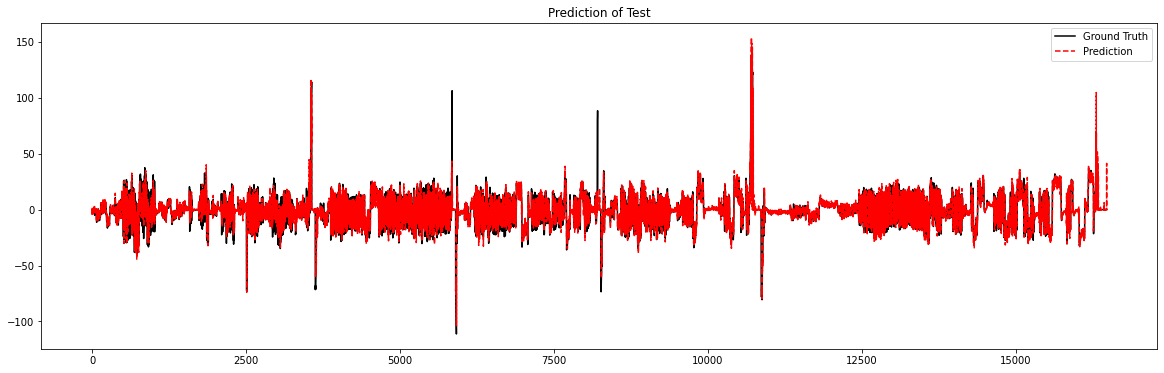

Average error is 0.27 degrees
Root Mean Squared Error is 3.28 degrees
Mean Absolute Error is 3.28 degrees


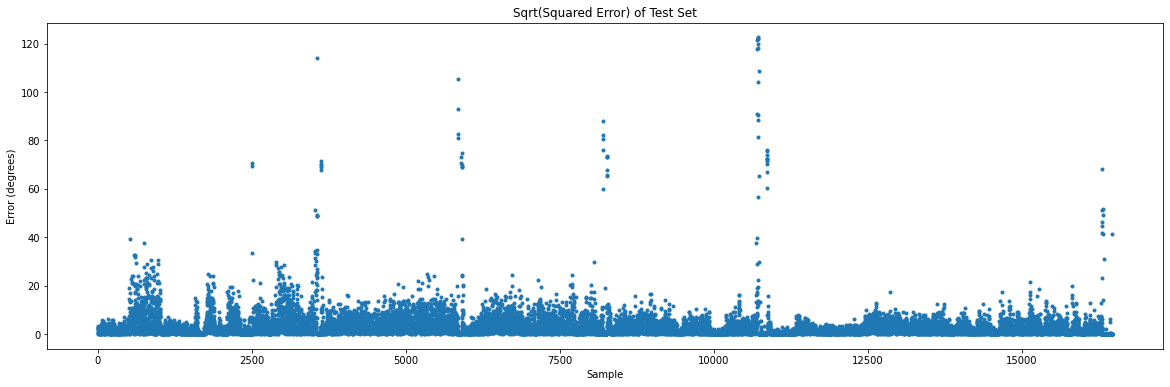

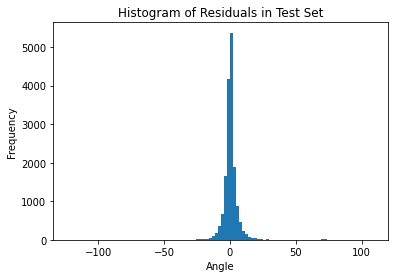

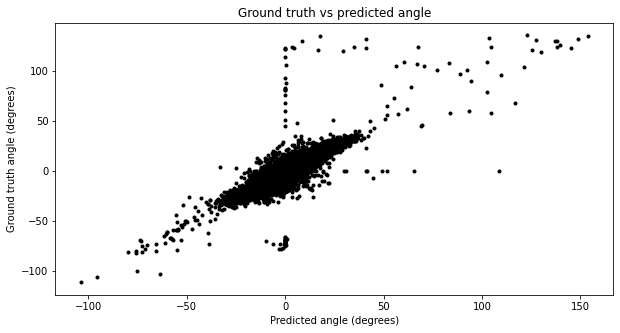

In [100]:
# Redo test set
Xtest = Testset
y_pred = model.predict(Xtest)
#y_pred = sc_y.inverse_transform(y_pred)
y_pred = sc_y.inverse_transform(y_pred)
y_new = Testy

plt.figure(figsize=(20,6))
plt.plot(y_new,'k')
plt.plot(y_pred,'r--')
plt.title('Prediction of Test')
#plt.axis([xmin, xmax, ymin, ymax])
plt.legend(labels=['Ground Truth','Prediction'])
plt.show()

# Squared-root of Squared Error

test_error = (y_pred - y_new)
print('Average error is {:4.2f} degrees'.format(np.sum(test_error)/test_error.shape[0]))
rmse = np.sqrt(test_error**2)
print('Root Mean Squared Error is {:4.2f} degrees'.format(np.sum(rmse)/test_error.shape[0]))
# Mean absolute error
print('Mean Absolute Error is {:4.2f} degrees'.format(np.sum(np.abs(test_error))/test_error.shape[0]))
plt.figure(figsize=(20,6))
plt.plot(rmse,'.')
plt.title('Sqrt(Squared Error) of Test Set')
plt.xlabel('Sample')
plt.ylabel('Error (degrees)')
plt.show()

plt.figure()
plt.hist(test_error,bins=100)
plt.title('Histogram of Residuals in Test Set')
plt.xlabel('Angle')
plt.ylabel('Frequency')
plt.show()

#plot scatterplot of data
plt.figure(figsize=(10,5))
plt.scatter(y_pred,y_new,marker='.',color='black')
plt.xlabel('Predicted angle (degrees)')
plt.ylabel('Ground truth angle (degrees)')
plt.title('Ground truth vs predicted angle')
plt.show()

In [101]:
save_notebookparams = 1
if save_notebookparams:
    pkl_filename = "depthmodelparam_cnn3v13.pkl"
    randata = {}
    randata['nsamps']=nsamps
    randata['n80p']=n80p
    randata['rannums']=rannums
    randata['test_set']=test_set
    modelhistory = history.history
    
    
    with open(pkl_filename, 'wb') as file:
        pickle.dump([randata,sc_y,modelhistory], file)
        
    model.save('depthmodel_cnn3v13.h5') 